In [15]:
import JSON
using Plots
using HDF5
using Trapz
include("../scripts/tools.jl")
include("../scripts/get_grid.jl")
include("../scripts/get_params.jl")

get_params (generic function with 2 methods)

In [16]:
border = import_border("../data/border.json")
dx = 20
Nx, Ny, xrange, yrange, isinside, isborder, n = get_grid(border, Float64(dx))

x = repeat(reshape(xrange,1,Nx),Ny,1)
y = repeat(reshape(yrange,Ny,1),1,Nx)
x_for_bx = repeat(reshape(xrange,1,Nx),Ny,1) .- dx/2
y_for_bx = repeat(reshape(yrange,Ny,1),1,Nx)
x_for_by = repeat(reshape(xrange,1,Nx),Ny,1)
y_for_by = repeat(reshape(yrange,Ny,1),1,Nx) .+ dx/2;

#=
temp = findall(isgrid)
id_xy = Int64.(zeros(length(temp),2))
for i=1:length(temp)
    id_xy[i,:] = [temp[i][1] temp[i][2]]
end
scatter(id_xy[:,2],id_xy[:,1], marker = (:circle, 2))
=#


temp = findall(isborder)
id_xy = Int64.(zeros(length(temp),2))
for i=1:length(temp)
    id_xy[i,:] = [temp[i][1] temp[i][2]]
end
scatter(id_xy[:,2],id_xy[:,1], marker = (:circle, 2))

temp = findall(isinside)
id_xy = Int64.(zeros(length(temp),2))
for i=1:length(temp)
    id_xy[i,:] = [temp[i][1] temp[i][2]]
end
scatter!(id_xy[:,2], id_xy[:,1], marker = (:circle, 2))
quiver!(vec(n[:,2]),vec(n[:,1]),quiver=(4*vec(n[:,4]),4*vec(n[:,3])))

savefig("map.svg")

In [17]:
recompute_param = true
sigma = 100.
if(recompute_param)
    bx, by, p, m, d = get_params(isinside, isborder, sigma, Float64(dx), "../data/pantagruel.h5",
        "../numerics/grid_params_" * string(dx) * ".h5")
else
    bx, by, p, m, d = get_params(isinside, "../numerics/grid_params_" * string(dx) * ".h5")
end


([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0])

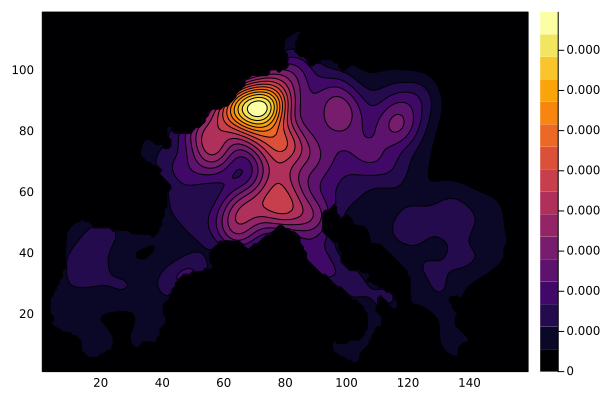

In [18]:
contour(d,fill=true)

In [19]:
interval = 100
Niter = 5000
th = zeros(Ny, Nx)



@time begin
    for k in 1:Niter
        if(mod(k,interval) == 0)
            temp = copy(th)
        end
        Threads.@threads for i in 2:Ny-1
            Threads.@threads for j in 2:Nx-1
                if(isinside[i,j] | isborder[i,j])
                    bij = (by[i-1,j] + by[i,j] + bx[i,j] + bx[i,j+1])
                    th[i,j] = (by[i,j] * th[i+1,j] + by[i-1,j] * th[i-1,j] + 
                        bx[i,j+1] * th[i,j+1] + bx[i,j] * th[i,j-1] + dx^2*p[i,j]) / bij
                    
                    if(isnan(th[i,j]))
                        #println([i, j])
                    end                   
                    
                end
            end
        end   
        if(mod(k,interval) == 0)
            println([k maximum(abs.(th-temp))])
        end

    end
end


[100.0 0.0016035756439152227]
[200.0 0.000894551473382299]
[300.0 0.0007204676133887311]
[400.0 0.0006469053912484535]
[500.0 0.0006128557754249975]
[600.0 0.0005785263854455047]
[700.0 0.00053830793699855]
[800.0 0.0004972886781911545]
[900.0 0.0004581122401285942]
[1000.0 0.00042197711105246283]
[1100.0 0.0003944249509267861]
[1200.0 0.0003925726280885611]
[1300.0 0.00039074851025805435]
[1400.0 0.0003863583725873254]
[1500.0 0.00037995277454649923]
[1600.0 0.0003719919056763832]
[1700.0 0.0003628560802653169]
[1800.0 0.00035285684419528174]
[1900.0 0.00034224765222390374]
[2000.0 0.0003312335281935308]
[2100.0 0.0003199683476187154]
[2200.0 0.00030860776090246844]
[2300.0 0.00029725082316922613]
[2400.0 0.0002859693240934158]
[2500.0 0.00027483206926581794]
[2600.0 0.0002638909967036529]
[2700.0 0.00025318530545803686]
[2800.0 0.0002427443088341974]
[2900.0 0.00023258942176951347]
[3000.0 0.00022273568757691375]
[3100.0 0.00021319300048849854]
[3200.0 0.00020396709916792322]
[3300.0

1.2552133566115802
-1.2297742425341902


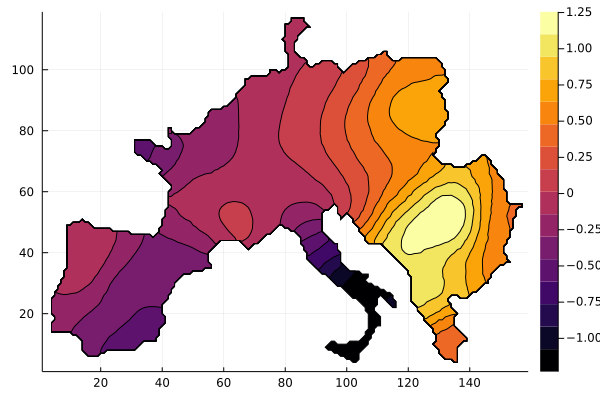

In [20]:
println(maximum(th))
println(minimum(th))
do_plot(isinside, th)
#do_plot(isgrid, p)
#contour(bx, fill=true)

In [21]:
fid = h5open("../numerics/stable_" * string(dx) * ".h5", "w")
write(fid, "th", th)
close(fid)